## Setup & Imports

You'll need to log into huggingface and accept the terms of the licence for this model - see the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) for details. And when you first run this notebook you need to uncomment the following two cells to install the requirements and log in to huggingface with an access token.

In [1]:
!pip install --upgrade -qq transformers diffusers ftfy
!pip install -qq accelerate

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from torchvision import transforms as tfms

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch_device, 'enabled')

cuda enabled


## Loading the models

This code (and that in the next section) comes from the [Huggingface example notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb). 

This will download and set up the relevant models and components we'll be using. Let's just run this for now and move on to the next section to check that it all works before diving deeper.

If you've loaded a pipeline, you can also access these components using `pipe.unet`, `pipe.vae` and so on.

In this notebook we aren't doing any memory-saving tricks - if you find yourself running out of GPU RAM, look at the pipeline code for inspiration with things like attention slicing, switching to half precision (fp16), keeping the VAE on the CPU and other modifications.

In [4]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

## A diffusion loop

If all you want is to make a picture with some text, you could ignore this notebook and use one of the existing tools (such as [DreamStudio](https://beta.dreamstudio.ai/)) or use the simplified pipeline from huggingface, as documented [here](https://huggingface.co/blog/stable_diffusion).

What we want to do in this notebook is dig a little deeper into how this works, so we'll start by checking that the example code runs. Again, this is adapted from the [HF notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb) and looks very similar to what you'll find if you inspect [the `__call__()` method of the stable diffusion pipeline](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L200).  

In [5]:
# Original loop
cache = {}
def cached_original():
    if not cache.get(MANUAL_SEED):
        cache[MANUAL_SEED] = original()
    return cache[MANUAL_SEED]
def original():
    
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    #num_inference_steps = 10            # Number of denoising steps
    #guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(MANUAL_SEED)   # Seed generator to create the inital latent noise
    batch_size = 1

    # Prep text 
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
      (batch_size, unet.in_channels, height // 8, width // 8),
      generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

    # Loop
    with autocast("cuda"):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            # Scale the latents (preconditioning):
            # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            guided_noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
            latents = scheduler.step(guided_noise_pred, t, latents).prev_sample

    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    # Display
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    orig = pil_images[0]
    return orig

It's working, but that's quite a bit of code! Let's look at the components one by one.

## Custom variation with many unconditionals

In [19]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [20]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [21]:
import gc
!pip install -Uqq pynvml

def free_gpu():
    gc.collect()
    torch.cuda.empty_cache()
    
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    free_gpu()

In [23]:
# variation with many unconditionals

prompt = ["a photograph of an astronaut riding a horse"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 10            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance

batch_size = 1
uncond_n = 2
uncond_noise_k = 0

In [24]:
# Prep text 
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
    prompt_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 


  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

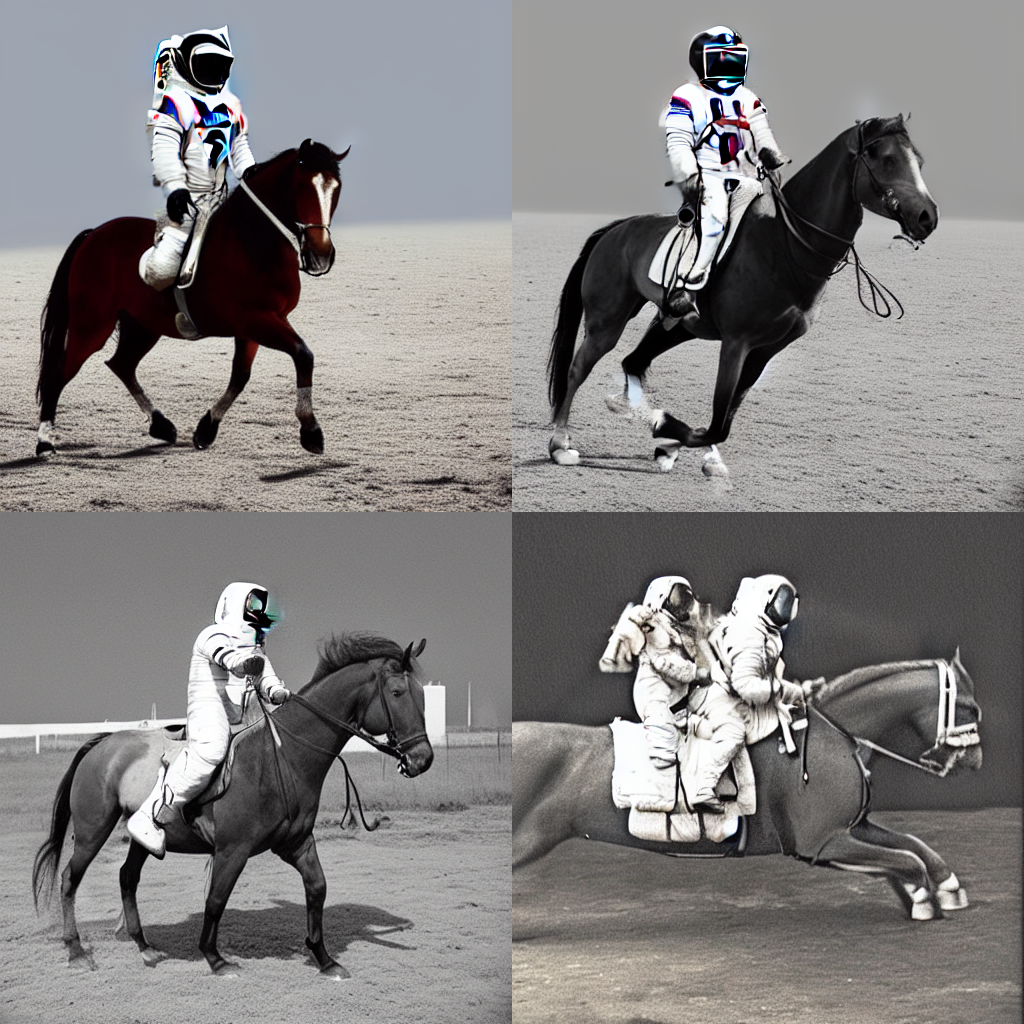

In [29]:
free_gpu()
MANUAL_SEED_1 = 1024
generator = torch.manual_seed(MANUAL_SEED)
# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Loop
max_sigma = None
imgs = []
N=2
# Prep latents

latents1 = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents1 = latents1.to(torch_device)
latents1 = latents1 * scheduler.init_noise_sigma

latents2 = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents2 = latents2.to(torch_device)
latents2 = latents2 * scheduler.init_noise_sigma

for k in tqdm(np.linspace(0, 1, N*N)): 

    latents = latents1*(1-k) + latents2*k
    lsigma = latents.std()
    #print('step k=', k)
    # print(latents1.mean(), latents1.std())
    # print(latents.mean(), latents.std())
    latents = latents / lsigma * latents1.std()

    with autocast("cuda"):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            # expand the latents to 
            latent_model_input = torch.cat([latents] * (uncond_n+1))
            sigma = scheduler.sigmas[i]

            # Scale the latents (preconditioning):
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            # shake text_embeddings
            uncond_noise = torch.randn((uncond_n,1,1)).to(torch_device)
            uncond_embeddings = uncond_embeddings + uncond_noise*uncond_noise_k
            text_embeddings = torch.cat([prompt_embeddings, uncond_embeddings])

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            noise_chunks  = noise_pred.chunk((uncond_n+1))
            noise_pred_text = noise_chunks[0]

            if not max_sigma:
                max_sigma = sigma
            modified_guidance = guidance_scale*(1.5+torch.sin(torch.tensor(i*np.pi/4))).abs()
            #print('i', i, 't', t, 'sigma', sigma, 'mgs', modified_guidance)
            guided_noise_pred = noise_pred[1:] + guidance_scale * (noise_pred_text - noise_pred[1:])

            mean_noise_pred = guided_noise_pred.mean(axis=0, keepdim=True)

            #print(noise_pred_text.shape, guided_noise_pred.shape, mean_noise_pred.shape)

            # compute the previous noisy sample x_t -> x_t-1
            # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
            latents = scheduler.step(mean_noise_pred, t, latents).prev_sample

    #image_grid([cached_original(), new_method], 1, 2)
    imgs.append(latents_to_pil(latents)[0])
image_grid(imgs, N,N)